Starting...

Current device is: cuda . Please abort and turn on cuda, if not already activated.

Importing data from file...

Preprocessing data...

Constructing Dataset...

Traing model on dataset...

Finished Training

Plotting input and output images at the beggining of training...

Plotting input and output images at the end of training...



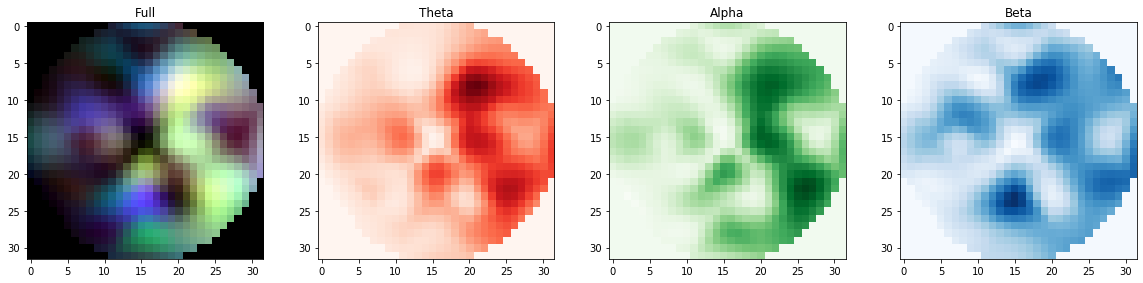

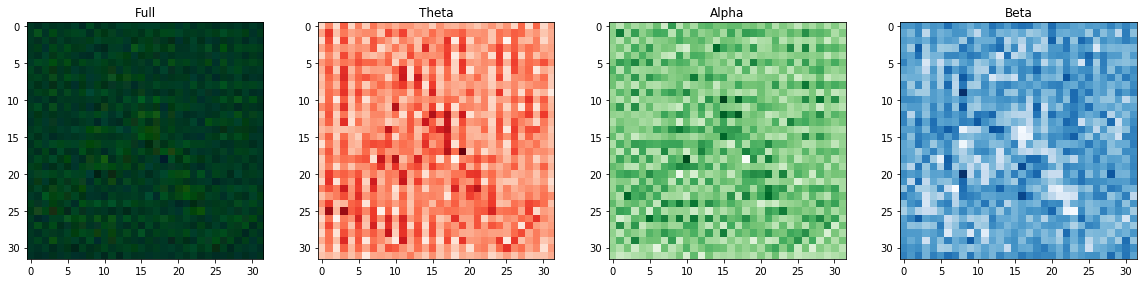

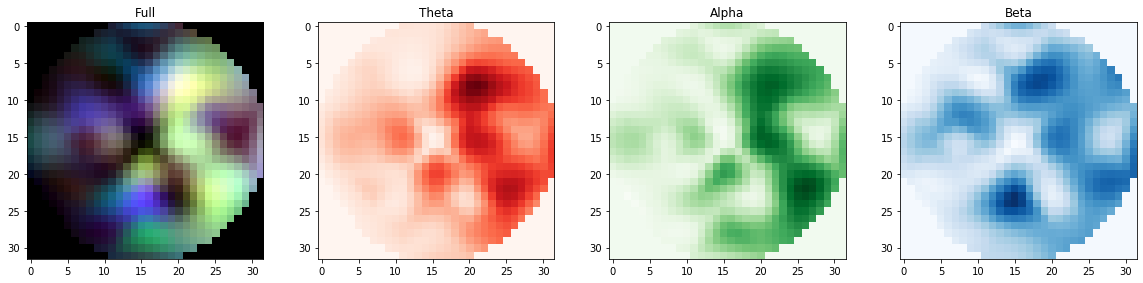

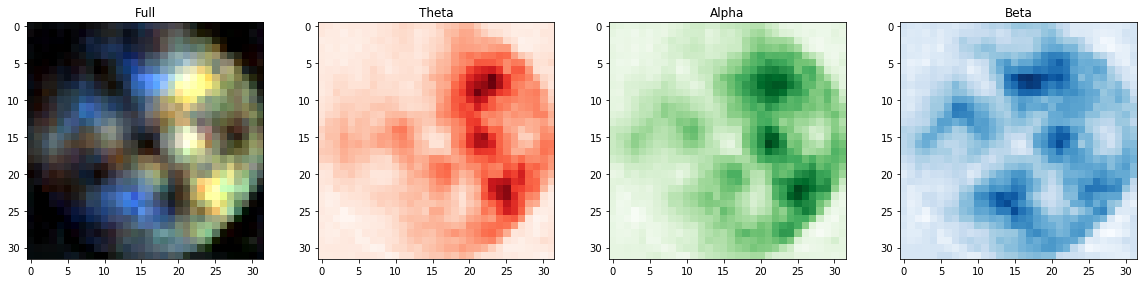

Saving autoencoder models alcohol group and control group:
Model1 saved as:  mymodel1.pth
Model2 saved as:  mymodel2.pth

Training classification models for images and features for 100 epochs..

Test loss before training on features 0.695122241973877
Test loss before training on images 0.7001901865005493
Test loss after Training on features 0.35775455832481384
Test loss after Training on images 0.48974287509918213

Summary of classifier accuracy:

Image accuracy: 82.85714285714286 %
Feature accuracy: 100.0 %

In  35  test cases, Changing classifier input form images to features lead to:

Correct cases increased by:  6
Accuracy increases by:  17.14285714285714 %


In [1]:
import numpy as np
import pandas as pd 
import random
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib 
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

print("Starting...")
print()
#GPU check     )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device is:", device, ". Please abort and turn on cuda, if not already activated.")
print()
print("Importing data from file...")


#Random Seed
seed = 123
random.seed = seed

#File Import
      
filenames_list = os.listdir('/kaggle/input/Alcoholics/SMNI_CMI_TRAIN/Train/') ## list of file names in the directory


EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
EEG_data_control = pd.DataFrame({})
number = 0

for file_name in filenames_list:
    temp_df = pd.read_csv('/kaggle/input/Alcoholics/SMNI_CMI_TRAIN/Train/' + file_name, engine = 'c') ## read from the file to df
    number += 1
    
    if 'a' in temp_df['subject identifier'].values:
                    
        EEG_data = EEG_data.append(temp_df) ## add the file data to the main df
        
        
    if 'c' in temp_df['subject identifier'].values:
                    
        EEG_data_control = EEG_data_control.append(temp_df) ## add the file data to the main df



EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name   

## replace some 'sensor position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

###same for control

EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name    
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

print()
print("Preprocessing data...")
print()

# build matrix 64 by 256 FOR each trial number

Alc_base = EEG_data['trial number'].unique()
Con_base = EEG_data_control['trial number'].unique()

##Train Test split 33% 

lstp_Alc1 = int(round((len(Alc_base)/100)*33.33))
lstp_Alc2 = int(round((len(Alc_base)/100)*66.66))

Alc_train_extractor = Alc_base[:lstp_Alc1]
Alc_train_classifier =Alc_base[lstp_Alc1:lstp_Alc2]
Alc_test = Alc_base[lstp_Alc2:]


lstp_Con1 = int(round((len(Con_base)/100)*33.33))
lstp_Con2 = int(round((len(Con_base)/100)*66.66))

Con_train_extractor = Con_base[:lstp_Con1]
Con_train_classifier = Con_base[lstp_Con1:lstp_Con2]
Con_test = Con_base[lstp_Con2:]


def trialfunction(input_data):
    
    trials_dic = {}
    
    dbc = 0
    
    if Alc_train_extractor.shape == Con_train_extractor.shape:
        
        print('Same shape error:')
        print(X_train.shape)
        print(y_train.shape)
        raise SystemExit 
    
    if (input_data.shape == Alc_train_extractor.shape) or (input_data.shape == Alc_train_classifier.shape) or (input_data.shape == Alc_test.shape):
        dbc = EEG_data
        
        
    if (input_data.shape == Con_train_extractor.shape) or (input_data.shape == Con_train_classifier.shape) or (input_data.shape == Con_test.shape):
        dbc = EEG_data_control
        
    
    for pos in input_data:               
        
        Trial = dbc.loc[dbc['trial number'] == pos]
    
        columns =['channel','time', 'sensor value']
 
        Trial = Trial.pivot_table(index='channel', columns='time', values = 'sensor value')
    
        trials_dic[pos] = Trial



    RGB_dic = {}
    
 

    for key in trials_dic:
        data = trials_dic.get(key)

        # Get real amplitudes of FFT (only in postive frequencies)

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

        # Get frequencies for amplitudes in Hz

        fs = 256    # Sampling rate

        fft_freq = fftfreq(fs, 1.0/fs)

        # Define EEG bands
        eeg_bands = {'Theta': (4, 7),
                 'Alpha': (8, 12),
                 'Beta': (13, 30),
                 }
    
        # Take the  sum of squared absolute values/amplitudes for each EEG band

        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        
    
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
    

           
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
               
                sqdvals = np.square(filterdch)
               
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
               



        extracted_df =  pd.DataFrame(eeg_band_fft)

    
   

        neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])

        neeg = neeg.drop_duplicates()


        #get names of source elctrodes:

        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)



        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})



        extracted_df = extracted_df.join(neeg)


        #get coordinates in 3d from robertoostenveld.nl/electrodes/plotting_1005.txt

        coords = pd.read_csv('/kaggle/input/httpsrobertoostenveldnlelectrodes/plotting_1005.txt', sep='\t',  header = None)

        coords = coords.drop(coords.columns[4], axis=1)

        #print(coords)
        testerd = pd.merge(e_names, coords, on=0,  how='inner')


        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']


        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        #filter values and coordinates
        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']

      
        #adapted from https://www.samuelbosch.com/2014/02/azimuthal-equidistant-projection.html

        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):
    
                self.t1 = pi / 2 ## polar latitude center of projection , https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection
                self.l0 = 0 ## arbitrary longitude center of projection
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                #ADDAPTED FOR 3D CARTESIAN TO SPHERICAL 
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
        
                ###
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


        
        #Projection df

        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():
    
            x = row['x']
            y = row['y']
            z = row['z']
    
    
            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))
    
            r = pd.Series(r)
    
            projected_df = projected_df.append(r,ignore_index=True)
    

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})


        ###map coodinate with valuies

        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31]) # drop row because i contains no values
        #print(new_df)

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        #map onto mesh

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)


        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)
     

        ##RGB construction

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid
    
    
    
        RGB_dic[key] = RGB


        
    ##creating new dict with new keys

    lendict = len(RGB_dic)
    #print('lendict: ',lendict)

    lenlist=np.arange(0,lendict)

    #print(lenlist)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    
    
    return final_dict
    
print("Constructing Dataset...")

###Dataset construction

class EEGRGBDataset(Dataset):

    def __init__(self, file, transform=None):
        
        self.file = file
        self.transform = transform
        
    def __len__(self):
        return len(self.file)


    def __getitem__(self, idx): 
          
        sample = self.file[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

####Tensor transform


class ToTensor(object):
    def __call__(self, sample):

        sample = sample.transpose((2, 0, 1))
        sample = torch.tensor(sample, dtype = torch.float, device = device)

        return sample 
    
### Function Call

final_dict1 = trialfunction(Alc_train_extractor)
final_dict2 = trialfunction(Con_train_extractor)
final_dict3 = trialfunction(Alc_train_classifier)
final_dict4 = trialfunction(Con_train_classifier)    
final_dict5 = trialfunction(Alc_test)
final_dict6 = trialfunction(Con_test)

##

eeg_dataset1 = EEGRGBDataset(final_dict1)
eeg_dataset2 = EEGRGBDataset(final_dict2)

eeg_dataset3 = EEGRGBDataset(final_dict3)
eeg_dataset4 = EEGRGBDataset(final_dict4)

eeg_dataset5 = EEGRGBDataset(final_dict5)
eeg_dataset6 = EEGRGBDataset(final_dict6)

##
    
transformed_dataset1 = EEGRGBDataset(eeg_dataset1, transform=transforms.Compose([ToTensor()]))
transformed_dataset2 = EEGRGBDataset(eeg_dataset2, transform=transforms.Compose([ToTensor()]))

transformed_dataset3 = EEGRGBDataset(eeg_dataset3, transform=transforms.Compose([ToTensor()]))
transformed_dataset4 = EEGRGBDataset(eeg_dataset4, transform=transforms.Compose([ToTensor()]))

transformed_dataset5 = EEGRGBDataset(eeg_dataset5, transform=transforms.Compose([ToTensor()]))
transformed_dataset6 = EEGRGBDataset(eeg_dataset6, transform=transforms.Compose([ToTensor()]))

###Batch construction

bsize = 10
workers = 0 


loader1_Alc_train_extractor = DataLoader(transformed_dataset1, batch_size=bsize, num_workers=workers)
loader2_Con_train_extractor = DataLoader(transformed_dataset2, batch_size=bsize, num_workers=workers)

loader3_Alc_train_classifier = DataLoader(transformed_dataset3, batch_size=bsize, num_workers=workers)
loader4_Con_train_classifier = DataLoader(transformed_dataset4, batch_size=bsize, num_workers=workers)

loader5_Alc_test = DataLoader(transformed_dataset5, batch_size=bsize, num_workers=workers)
loader6_Con_test = DataLoader(transformed_dataset6, batch_size=bsize, num_workers=workers)


###Autoencoder

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        #Encoder Convolutions
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels= 8, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels= 12, out_channels=16, kernel_size=3, stride=1, padding=1)
        

        #Decoder Convolutions
        self.deconv1 = nn.ConvTranspose2d(in_channels= 16, out_channels= 12, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels= 12, out_channels= 8, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels= 8, out_channels= 3, kernel_size=3, stride=1, padding=1)
        
        #Shared functions
        self.pool = nn.MaxPool2d(kernel_size= 2,return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size= 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.25, inplace=False)
        
        
    def forward(self,x):
        #Encoder
        encoded = self.conv1(x)
        encoded, indices1 = self.pool(encoded)
        encoded = self.relu(encoded)
        encoded = self.dropout(encoded)
        encoded = self.conv2(encoded)
        encoded, indices2 = self.pool(encoded)
        encoded = self.relu(encoded)
        encoded = self.dropout(encoded)
        encoded = self.conv3(encoded)
        encoded = self.relu(encoded)
        
        #Decoder
        
        decoded = self.deconv1(encoded)
        decoded = self.unpool(decoded, indices2)
        decoded = self.relu(decoded)
        decoded = self.deconv2(decoded)  
        decoded = self.unpool(decoded, indices1)
        decoded = self.relu(decoded)
        decoded = self.deconv3(decoded)

   
        return decoded, encoded
    


#Train 
print()
print("Traing model on dataset...")
print()
model1 = Autoencoder().cuda()
model2 = Autoencoder().cuda()

distance = nn.MSELoss()

optimizer1 = torch.optim.Adam(model1.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# Tensor construction
# for pytorch, the right format for image is [batch, channels, height, width]

#Training procedure

num_epochs = 1000

def trainer(loaderx, model, optimizer):
    
    for epoch in range(num_epochs):
        #print(epoch)
        
        for i, batch in enumerate(loaderx):
            
           
            #input
            inputs = batch
    
            #optimizer zeroing
            optimizer.zero_grad()
    
    
            #forward
            output  = model(inputs)
            loss = distance(output[0],inputs)
    
            #backward
            loss.backward()
            optimizer.step()
            
        
            # images
            
            if i == 1 and epoch == 9:
           
                firstimg_inp = inputs
                firstimg_out = output[0]
              
                
            
            if i == 1  and epoch == num_epochs-1:
        
                lastimg_inp = inputs
                lastimg_out = output[0]
            
                
                return firstimg_inp, firstimg_out, lastimg_inp, lastimg_out


firstimg_inp1, firstimg_out1, lastimg_inp1, lastimg_out1 = trainer(loader1_Alc_train_extractor, model1, optimizer1)
firstimg_inp2, firstimg_out2, lastimg_inp2, lastimg_out2 = trainer(loader2_Con_train_extractor, model2, optimizer2)

    
print('Finished Training')
print()

##Training starting
for i in firstimg_inp1:
    RGB1 = i.permute(1, 2, 0)
    RGB1 = RGB1.cpu()
    RGB1 = RGB1.detach().numpy()
    break
    
for i in firstimg_out1:
    RGB12 = i.permute(1, 2, 0)
    RGB12 = RGB12.cpu()
    RGB12 = RGB12.detach().numpy()
    break

##Training Ending
for i in lastimg_inp1:
    RGB2 = i.permute(1, 2, 0)
    RGB2 = RGB2.cpu()
    RGB2 = RGB2.detach().numpy()
    break
for i in lastimg_out1:
    RGB22 = i.permute(1, 2, 0)
    RGB22 = RGB22.cpu()
    RGB22 = RGB22.detach().numpy()
    break


### Image Plotting
print("Plotting input and output images at the beggining of training...")
print()

plt.subplot(441)
plt.imshow(RGB1, interpolation='none', origin='upper')
plt.title('Full')


plt.subplot(442)
plt.imshow(RGB1[:,:,0], interpolation='none', origin='upper', cmap = 'Reds')
plt.title('Theta')


print("Plotting input and output images at the end of training...")
print()
plt.subplot(443)
plt.imshow(RGB1[:,:,1], interpolation='none', origin='upper', cmap = 'Greens')
plt.title('Alpha')


plt.subplot(444)
plt.imshow(RGB1[:,:,2], interpolation='none', origin='upper', cmap = 'Blues')
plt.title('Beta')

plt.gcf().set_size_inches(20, 20)

plt.show()

plt.subplot(441)
plt.imshow(RGB12, interpolation='none', origin='upper')
plt.title('Full')


plt.subplot(442)
plt.imshow(RGB12[:,:,0], interpolation='none', origin='upper', cmap = 'Reds')
plt.title('Theta')


plt.subplot(443)
plt.imshow(RGB12[:,:,1], interpolation='none', origin='upper', cmap = 'Greens')
plt.title('Alpha')


plt.subplot(444)
plt.imshow(RGB12[:,:,2], interpolation='none', origin='upper', cmap = 'Blues')
plt.title('Beta')

plt.gcf().set_size_inches(20, 20)

plt.show()

##########################

plt.subplot(441)
plt.imshow(RGB2, interpolation='none', origin='upper')
plt.title('Full')


plt.subplot(442)
plt.imshow(RGB2[:,:,0], interpolation='none', origin='upper', cmap = 'Reds')
plt.title('Theta')


plt.subplot(443)
plt.imshow(RGB2[:,:,1], interpolation='none', origin='upper', cmap = 'Greens')
plt.title('Alpha')


plt.subplot(444)
plt.imshow(RGB2[:,:,2], interpolation='none', origin='upper', cmap = 'Blues')
plt.title('Beta')

plt.gcf().set_size_inches(20, 20)

plt.show()

plt.subplot(441)
plt.imshow(RGB22, interpolation='none', origin='upper')
plt.title('Full')


plt.subplot(442)
plt.imshow(RGB22[:,:,0], interpolation='none', origin='upper', cmap = 'Reds')
plt.title('Theta')


plt.subplot(443)
plt.imshow(RGB22[:,:,1], interpolation='none', origin='upper', cmap = 'Greens')
plt.title('Alpha')


plt.subplot(444)
plt.imshow(RGB22[:,:,2], interpolation='none', origin='upper', cmap = 'Blues')
plt.title('Beta')

plt.gcf().set_size_inches(20, 20)

plt.show()


#Saving & Loading Model

torch.save({'model_state_dict': model1.state_dict(),'optimizer_state_dict': optimizer1.state_dict()}, 'mymodel1.pth')
torch.save({'model_state_dict': model2.state_dict(),'optimizer_state_dict': optimizer2.state_dict()}, 'mymodel2.pth')

the_model1 = Autoencoder().cuda()
the_model2 = Autoencoder().cuda()

modelname1 = 'mymodel1.pth'
modelname2 = 'mymodel2.pth'


the_model1.load_state_dict(torch.load(modelname1)['model_state_dict'])
the_model1.eval()
the_model2.load_state_dict(torch.load(modelname2)['model_state_dict'])
the_model2.eval()

print("Saving autoencoder models alcohol group and control group:")
print("Model1 saved as: ", modelname1)
print("Model2 saved as: ", modelname2)


####Warmstarting Extractors on classifer training pool (basically tesing extractor)


def feature_extractor(loader, model):
        
    with torch.no_grad():
        
        outputlist = 0
        imagebatch = 0
        n = 0
        
        
        for batch in loader:
            n += 1
            
            inputs = batch

        
            #forward
        
            decoded, encoded  = model(inputs)
            
         
            if n == 1:
                outputlist = encoded
                imagebatch = batch
                
            else:
                outputlist = torch.cat((outputlist, encoded), dim=0, out=None)
                imagebatch = torch.cat([imagebatch, batch], dim=0, out=None)
                    
        return outputlist, imagebatch

### images for input

features_Alc_train_classifier, images_Alc_train_classifier = feature_extractor(loader3_Alc_train_classifier, the_model1)  
features_Con_train_classifier, images_Con_train_classifier = feature_extractor(loader4_Con_train_classifier, the_model2)

features_Alc_test_classifier, images_Alc_test_classifier = feature_extractor(loader5_Alc_test, the_model1)
features_Con_test_classifier, images_Con_test_classifier = feature_extractor(loader6_Con_test, the_model2)

        
import numpy as np
    

##Labels

y_Alc_train_classifier = np.ones([features_Alc_train_classifier.shape[0]])
y_Con_train_classifier = np.zeros([features_Con_train_classifier.shape[0]])

y_Alc_test_classifier = np.ones([features_Alc_test_classifier.shape[0]])
y_Con_test_classifier= np.zeros([features_Con_test_classifier.shape[0]])

features_train_classifier = torch.cat([features_Alc_train_classifier, features_Con_train_classifier], dim=0)
y_train_classifier = np.concatenate([y_Alc_train_classifier, y_Con_train_classifier], axis=0)

features_test_classifier = torch.cat([features_Alc_test_classifier, features_Con_test_classifier], dim=0)
y_test_classifier = np.concatenate([y_Alc_test_classifier, y_Con_test_classifier], axis=0)

images_train_classifier = torch.cat([images_Alc_train_classifier, images_Con_train_classifier], dim=0)
images_test_classifier = torch.cat([images_Alc_test_classifier, images_Con_test_classifier], dim=0)




###into multiarray
features_train_classifier = features_train_classifier.cpu().numpy()

features_test_classifier = features_test_classifier.cpu().numpy()

images_train_classifier = images_train_classifier.cpu().numpy()

images_test_classifier = images_test_classifier.cpu().numpy()


###

from sklearn.utils import shuffle

S_features_train_classifier, S_y_train_classifier = shuffle(features_train_classifier, y_train_classifier, random_state=0)
S_features_test_classifier, S_y_test_classifier = shuffle(features_test_classifier, y_test_classifier, random_state=0)
S_images_train_classifier, S_y_train_classifier = shuffle(images_train_classifier, y_train_classifier, random_state=0)
S_images_test_classifier, S_y_test_classifier = shuffle(images_test_classifier, y_test_classifier, random_state=0)


###back to tensor
S_features_train_classifier = torch.tensor(S_features_train_classifier, dtype=torch.float, device = device)
S_y_train_classifier = torch.tensor(S_y_train_classifier, dtype=torch.float, device = device)

S_features_test_classifier = torch.tensor(S_features_test_classifier, dtype=torch.float, device = device)
S_y_test_classifier = torch.tensor(S_y_test_classifier, dtype=torch.float, device = device)

S_images_train_classifier = torch.tensor(S_images_train_classifier, dtype=torch.float, device = device)

S_images_test_classifier = torch.tensor(S_images_test_classifier, dtype=torch.float, device = device)




###flatten

Flat_S_features_train_classifier = torch.flatten(S_features_train_classifier,start_dim=1, end_dim=-1)
Flat_S_features_test_classifier = torch.flatten(S_features_test_classifier,start_dim=1, end_dim=-1)
Flat_S_images_train_classifier = torch.flatten(S_images_train_classifier,start_dim=1, end_dim=-1)
Flat_S_images_test_classifier = torch.flatten(S_images_test_classifier,start_dim=1, end_dim=-1)


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

####
print()
print("Training classification models for images and features for 100 epochs..")
print()
#Train FeedforwardNeuralNetModel

model3 = FeedforwardNeuralNetModel(1024,10).cuda()
model4 = FeedforwardNeuralNetModel(3072,10).cuda()

distance =  nn.BCELoss()

FFoptimizer1 = torch.optim.SGD(model3.parameters(), lr = 0.01)
FFoptimizer2 = torch.optim.SGD(model4.parameters(), lr = 0.01)

#Training procedure

FFnum_epochs = 100

def FFtrainer(loaderx,labels, model, optimizer):
    
    for epoch in range(FFnum_epochs):
                  
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(loaderx)
        # Compute Loss
        loss = distance(y_pred.squeeze(), labels)
   
        # Backward pass
        loss.backward()
        optimizer.step()
        
        #Print loss per epoch
        #if epoch == 0 or epoch == FFnum_epochs-1:
            #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))


### Determine test loss before training on test set

model3.eval()
y_pred1 = model3(Flat_S_features_test_classifier)
before_train = distance(y_pred1.squeeze(), S_y_test_classifier)
print('Test loss before training on features' , before_train.item())

model4.eval()
y_pred2 = model4(Flat_S_images_test_classifier)
before_train = distance(y_pred2.squeeze(), S_y_test_classifier)
print('Test loss before training on images' , before_train.item())


#Training Call

model3.train()
Model_features_train_classifier = FFtrainer(Flat_S_features_train_classifier,S_y_train_classifier,model3,FFoptimizer1) 

model4.train()
Model_images_train_classifier = FFtrainer(Flat_S_images_train_classifier,S_y_train_classifier,model4,FFoptimizer2)  


# Evaluation
model3.eval()
y_pred3 = model3(Flat_S_features_test_classifier)
after_train = distance(y_pred3.squeeze(), S_y_test_classifier) 
print('Test loss after Training on features' , after_train.item())

model4.eval()
y_pred4 = model4(Flat_S_images_test_classifier)
after_train = distance(y_pred4.squeeze(), S_y_test_classifier) 
print('Test loss after Training on images' , after_train.item())


#Accuracy

output_pred3 = (y_pred3>0.5).float()
correct3 = (output_pred3.squeeze() == S_y_test_classifier).cpu().numpy().sum()
incorrect3 = (output_pred3.squeeze() != S_y_test_classifier).cpu().numpy().sum()
total3 = correct3 + incorrect3
accuracy3 = 100 * correct3 / total3


output_pred4 = (y_pred4>0.5).float()
correct4 = (output_pred4.squeeze() == S_y_test_classifier).cpu().numpy().sum()
incorrect4 = (output_pred4.squeeze() != S_y_test_classifier).cpu().numpy().sum()
total4 = correct4 + incorrect4
accuracy4 = 100 * correct4 / total4


print()
print("Summary of classifier accuracy:")
print()
print('Image accuracy:',accuracy4,'%')
print('Feature accuracy:',accuracy3,'%')
print()
print('In ',total4,' test cases, Changing classifier input form images to features lead to:' )
print()
print('Correct cases increased by: ', correct3 - correct4)
print('Accuracy increases by: ', accuracy3 - accuracy4,'%')